### Setup



```
git clone https://github.com/tensorflow/models
```

In [1]:
import sys
import os
import tensorflow as tf
import six.moves.urllib as urllib
import numpy as np
import skimage.io as io
import tarfile
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
sys.path.append("/home/kolga/kolga/term7-DL/models/research")
sys.path.append("/home/kolga/kolga/term7-DL/models/research/slim")
sys.path.append("/home/kolga/kolga/term7-DL/models/research/object_detection")

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Download the model.

In [2]:
from utils import label_map_util
from utils import visualization_utils as vis_util

checkpoints_dir = '/home/kolga/kolga/term7-DL/hw4/tensorflow_notes/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
PATH_TO_CKPT = '/home/kolga/kolga/term7-DL/data/frozen_inference_graph.pb'

PATH_TO_LABELS = os.path.join('/home/kolga/kolga/term7-DL/data', 'pascal_label_map.pbtxt')

NUM_CLASSES = 20

#opener = urllib.request.URLopener()
#opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, checkpoints_dir + "/" + MODEL_FILE)
tar_file = tarfile.open(checkpoints_dir + "/" + MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, checkpoints_dir)
    
    
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [3]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [4]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [13]:
PATH_TO_VOC = '/home/kolga/kolga/term7-DL/data/VOCdevkit/VOC2012/'
PATH_TO_TEST_IMAGES_DIR = PATH_TO_VOC + 'JPEGImages'

VAL_PATH = PATH_TO_VOC + 'ImageSets/Main/val.txt'
tests=[]
with open(VAL_PATH) as f:
    tests = f.read().splitlines()
    
TRAIN_PATH = PATH_TO_VOC + 'ImageSets/Main/train.txt'
trains=[]
with open(TRAIN_PATH) as f:
    trains = f.read().splitlines()
    
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, tests[i] + ".jpg") for i in range(len(tests)) ]
TRAIN_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, trains[i] + ".jpg") for i in range(len(trains)) ]
TEST_IMAGE_PATHS = TEST_IMAGE_PATHS[:20]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

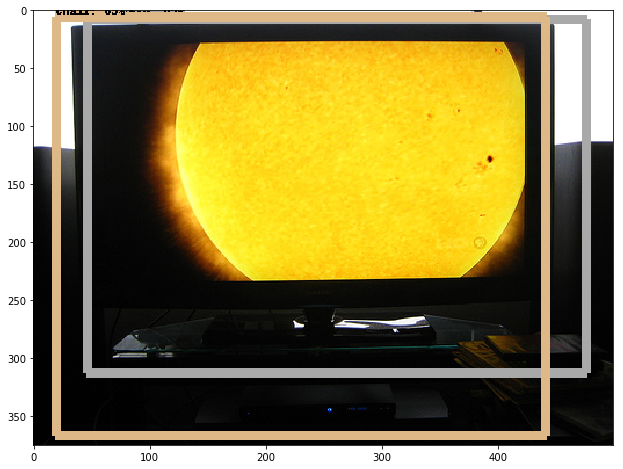

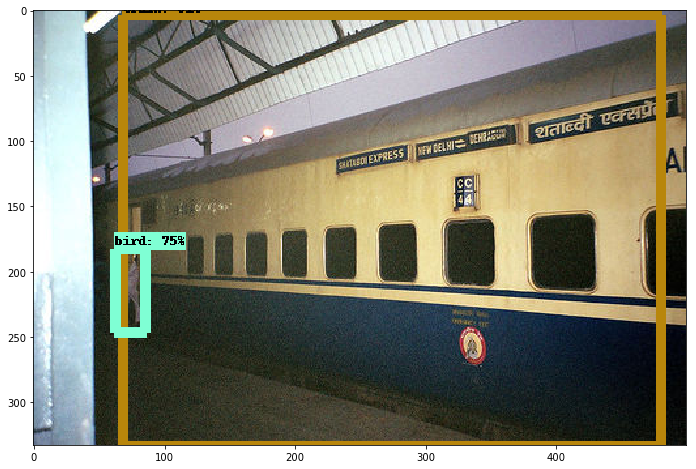

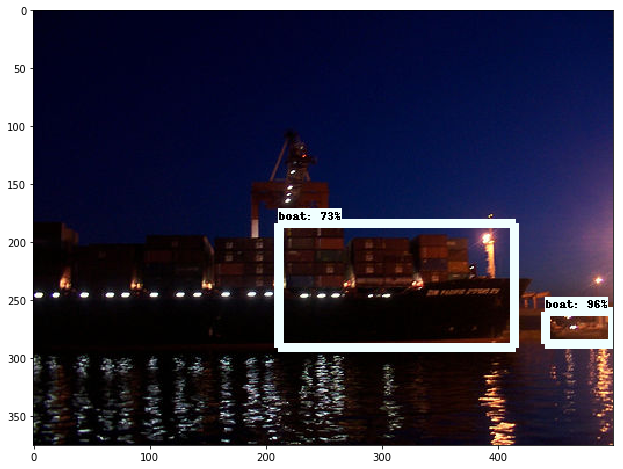

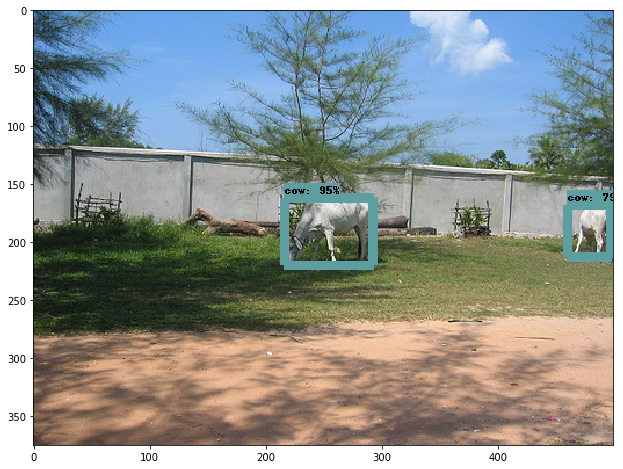

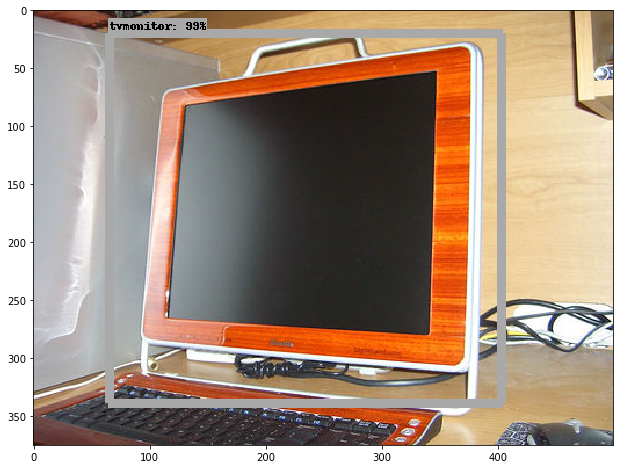

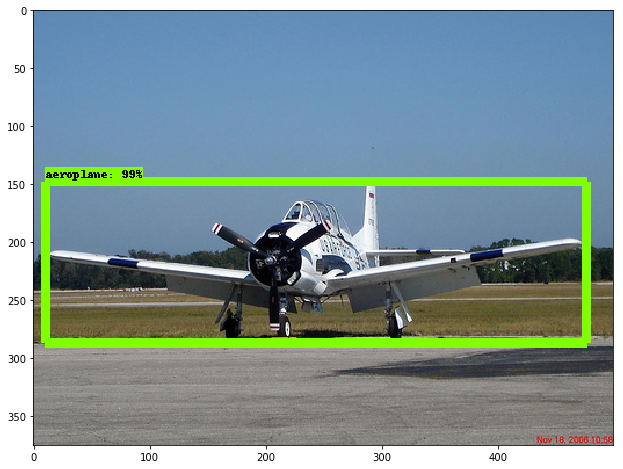

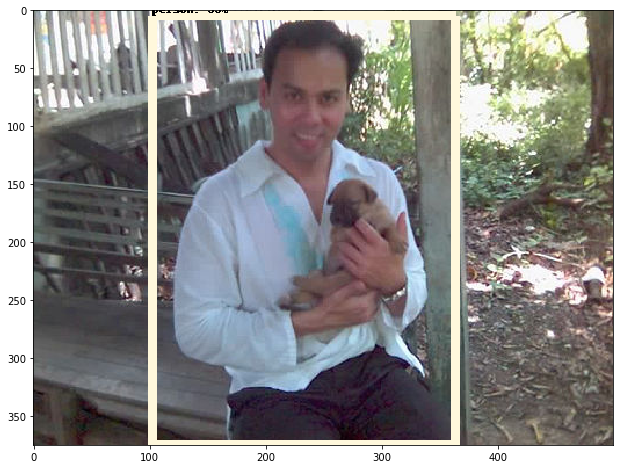

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


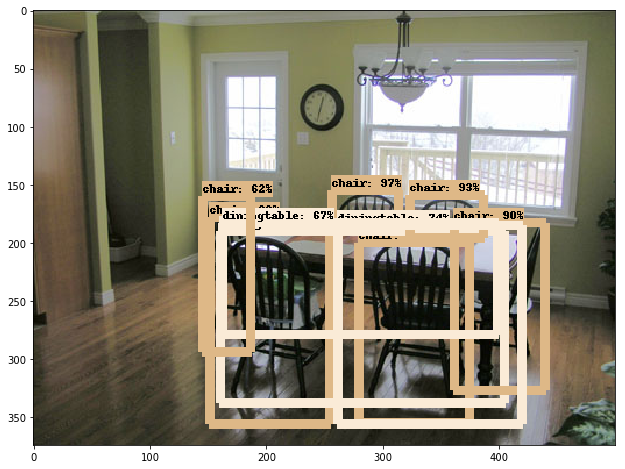

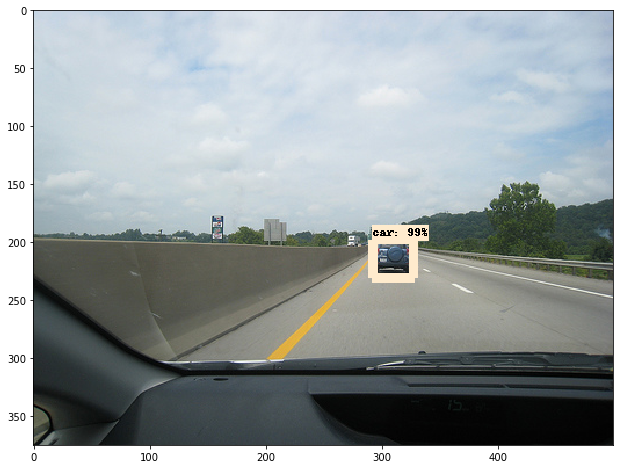

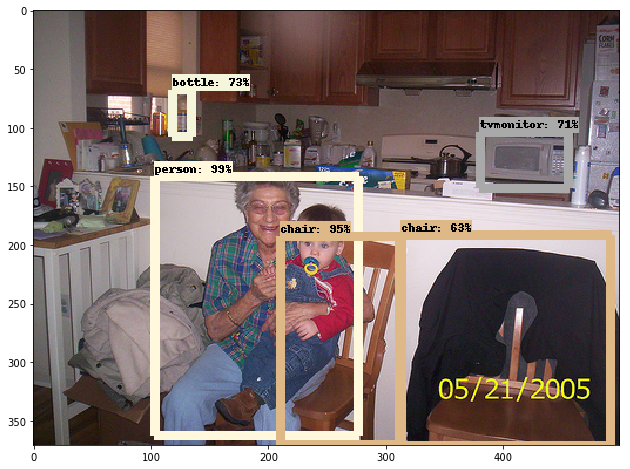

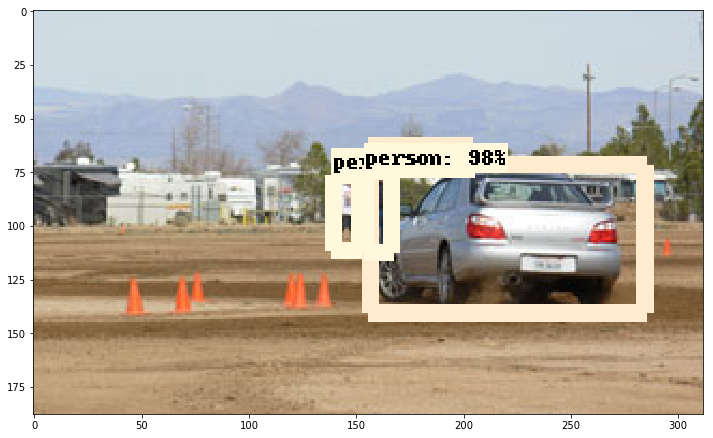

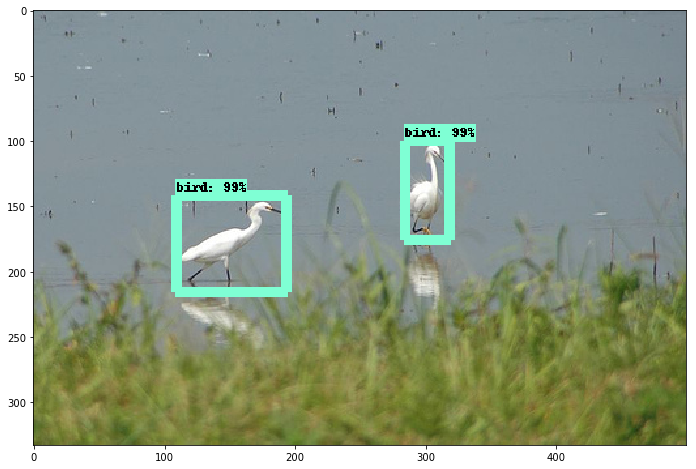

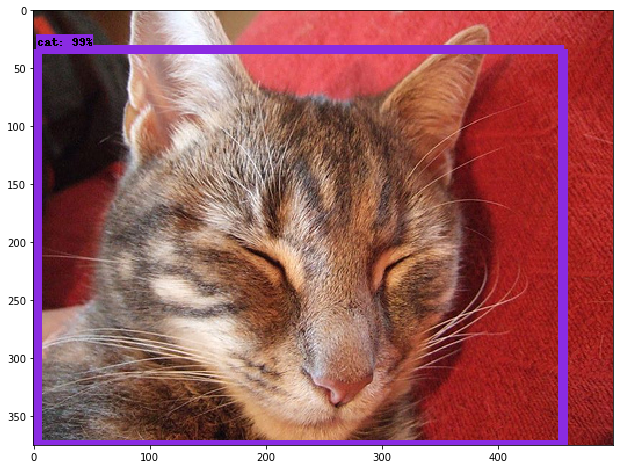

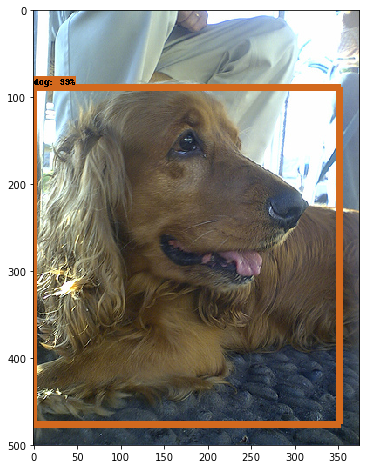

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [6]:
with detection_graph.as_default():
      with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
                 np.squeeze(scores),
                 category_index,
                 use_normalized_coordinates=True,
                 line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)

In [10]:
def get_box_and_class(lines):
    bx = [0,0,0,0]
    cl = ""
    for s in lines:
        if s.find('</object>') != -1:
            return bx, cl
        if s.find('<name>') != -1:
            pos1 = s.find('<name>') + len('<name>')
            pos2 = s.find('</name>')
            cl = s[pos1:pos2]
        if s.find('<xmax>') != -1:
            bx[3] = int(s[s.find('<xmax>') + len('<xmax>'):s.find('</xmax>')])
        if s.find('<xmin>') != -1:
            bx[1] = int(s[s.find('<xmin>') + len('<xmin>'):s.find('</xmin>')])
        if s.find('<ymax>') != -1:
            bx[2] = int(s[s.find('<ymax>') + len('<ymax>'):s.find('</ymax>')])
        if s.find('<ymin>') != -1:
            bx[0] = int(s[s.find('<ymin>') + len('<ymin>'):s.find('</ymin>')])
            
    return bx, cl

In [31]:
def get_boxes_and_classes(name):
    xml_path = PATH_TO_VOC + 'Annotations/' + name + '.xml'
    bxs = []
    clss = []
    xsize = 1
    ysize = 1
    with open(xml_path) as f:
        lines = f.read().splitlines()
        for i in range(len(lines)):
            s = lines[i]
            if s.find('<object>') != -1:
                bx, cl = get_box_and_class(lines[i + 1:])
                bxs.append(bx)
                clss.append(cl)
            if s.find('<width>') != -1:
                xsize = int(s[s.find('<width>') + len('<width>') : s.find('</width>')])
            if s.find('<height>') != -1:
                ysize = int(s[s.find('<height>') + len('<height>') : s.find('</height>')])
                
    
    for i in range(len(bxs)):
        bxs[i][0] /= ysize
        bxs[i][2] /= ysize
        bxs[i][1] /= xsize
        bxs[i][3] /= xsize
        
        for j in range(1, len(category_index) + 1):
            if (category_index[j]['name'] == clss[i]):
                clss[i] = category_index[j]['id']
    
    return bxs, clss
    

In [55]:
def IoU(bx1, bx2):
    overlap = min(bx1[2], bx2[2]) - max(bx1[0], bx2[0])) * (min(bx1[3], bx2[3]) - max(bx1[1], bx2[1])) 
    union = (bx1[2] - bx1[0]) * (bx1[3] - bx1[1]) + (bx2[2] - bx2[0]) * (bx2[3] - bx2[1]) - overlap
    return overlap/union
    
    
def rght_detect(bx1, cl1, bx2, cl2):
    if cl1 != cl2:
        return False
    if (min(bx1[2], bx2[2]) - max(bx1[0], bx2[0])) < 0:
        return False
    if (min(bx1[3], bx2[3]) - max(bx1[1], bx2[1])) < 0:
        return False
    
    if (IoU(bx1, bx2) < 0.5):
        return False
    return True
    
def dfs(u, used, px, g):
    if (used[u] == 1):
        return False
    used[u] = 1
    for i in range(len(g[u])):
        v = g[u][i]
        if (px[v] == -1):
            px[v] = u
            return True
        elif (dfs(px[v], used, px, g)):
            px[v] = u
            return True
    return False
    
def check_class(aboxes, aclasses, boxes, scores, classes):
    for i in range(len(scores)):
        if (scores[i] < 0.5):
            boxes = boxes[:i]
            classes = classes[:i]
    n = len(aboxes)
    m = len(boxes)
    g = []
    px = [-1] * m
    for i in range(n):
        g.append([])
        for j in range(m):
            if (rght_detect(aboxes[i], aclasses[i], boxes[j], classes[j])):
                g[i].append(j)
    
    for i in range(n):
        used = [0]*n
        fins = dfs(i, used, px, g)
    
    cnt = 0
    for i in range(m):
        if (px[i] != -1):
            cnt += 1
    return cnt
    
    

In [56]:
cnt = 0
rght = 0

with detection_graph.as_default():
      with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for i in range(len(trains)):
            image_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, trains[i] + ".jpg") 
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            
            (aboxes, aclasses) = get_boxes_and_classes(trains[i])  
            cnt += len(aboxes)
            rght += check_class(aboxes, aclasses, boxes[0], scores[0], classes[0])
            if (i % 10 == 0):
                print("i=", i, " Accuracy: ", rght/cnt, " rght=", rght, " cnt=", cnt)

print("Accuracy: ", rght/cnt)
            

i= 0  Accuracy:  1.0  rght= 2  cnt= 2
i= 10  Accuracy:  0.6857142857142857  rght= 24  cnt= 35
i= 20  Accuracy:  0.7307692307692307  rght= 38  cnt= 52
i= 30  Accuracy:  0.7397260273972602  rght= 54  cnt= 73
i= 40  Accuracy:  0.7444444444444445  rght= 67  cnt= 90
i= 50  Accuracy:  0.7350427350427351  rght= 86  cnt= 117
i= 60  Accuracy:  0.7586206896551724  rght= 110  cnt= 145
i= 70  Accuracy:  0.7541899441340782  rght= 135  cnt= 179
i= 80  Accuracy:  0.7355769230769231  rght= 153  cnt= 208
i= 90  Accuracy:  0.7533039647577092  rght= 171  cnt= 227
i= 100  Accuracy:  0.7330827067669173  rght= 195  cnt= 266
i= 110  Accuracy:  0.7386759581881533  rght= 212  cnt= 287
i= 120  Accuracy:  0.7412140575079872  rght= 232  cnt= 313
i= 130  Accuracy:  0.7477744807121661  rght= 252  cnt= 337
i= 140  Accuracy:  0.7597765363128491  rght= 272  cnt= 358
i= 150  Accuracy:  0.772020725388601  rght= 298  cnt= 386
i= 160  Accuracy:  0.7802469135802469  rght= 316  cnt= 405
i= 170  Accuracy:  0.7790697674418605

i= 1370  Accuracy:  0.7808657156910969  rght= 3175  cnt= 4066
i= 1380  Accuracy:  0.780648306117475  rght= 3203  cnt= 4103
i= 1390  Accuracy:  0.7813029789295229  rght= 3226  cnt= 4129
i= 1400  Accuracy:  0.7807396733909702  rght= 3251  cnt= 4164
i= 1410  Accuracy:  0.7798712139279752  rght= 3270  cnt= 4193
i= 1420  Accuracy:  0.7793038124556003  rght= 3291  cnt= 4223
i= 1430  Accuracy:  0.7792116377287658  rght= 3321  cnt= 4262
i= 1440  Accuracy:  0.7791267802941864  rght= 3337  cnt= 4283
i= 1450  Accuracy:  0.7798931971209658  rght= 3359  cnt= 4307
i= 1460  Accuracy:  0.7796143250688705  rght= 3396  cnt= 4356
i= 1470  Accuracy:  0.7793513019643673  rght= 3412  cnt= 4378
i= 1480  Accuracy:  0.7798727850976829  rght= 3433  cnt= 4402
i= 1490  Accuracy:  0.7791273054430949  rght= 3464  cnt= 4446
i= 1500  Accuracy:  0.7803571428571429  rght= 3496  cnt= 4480
i= 1510  Accuracy:  0.7810901001112347  rght= 3511  cnt= 4495
i= 1520  Accuracy:  0.7817416352758697  rght= 3528  cnt= 4513
i= 1530  

i= 2700  Accuracy:  0.7805441478439425  rght= 6082  cnt= 7792
i= 2710  Accuracy:  0.7807062436028659  rght= 6102  cnt= 7816
i= 2720  Accuracy:  0.7804940157881335  rght= 6130  cnt= 7854
i= 2730  Accuracy:  0.7802309351605127  rght= 6149  cnt= 7881
i= 2740  Accuracy:  0.7806051398911255  rght= 6166  cnt= 7899
i= 2750  Accuracy:  0.7806818181818181  rght= 6183  cnt= 7920
i= 2760  Accuracy:  0.7805062334718549  rght= 6198  cnt= 7941
i= 2770  Accuracy:  0.7805092186128183  rght= 6223  cnt= 7973
i= 2780  Accuracy:  0.7810976372046505  rght= 6248  cnt= 7999
i= 2790  Accuracy:  0.7811137411237075  rght= 6270  cnt= 8027
i= 2800  Accuracy:  0.7813005097600398  rght= 6284  cnt= 8043
i= 2810  Accuracy:  0.7815365551425031  rght= 6307  cnt= 8070
i= 2820  Accuracy:  0.7816361838853189  rght= 6325  cnt= 8092
i= 2830  Accuracy:  0.7819975339087546  rght= 6342  cnt= 8110
i= 2840  Accuracy:  0.7815260058881256  rght= 6371  cnt= 8152
i= 2850  Accuracy:  0.7818003913894325  rght= 6392  cnt= 8176
i= 2860 

i= 4020  Accuracy:  0.7985169108337855  rght= 8830  cnt= 11058
i= 4030  Accuracy:  0.7982851985559567  rght= 8845  cnt= 11080
i= 4040  Accuracy:  0.7983602126317686  rght= 8861  cnt= 11099
i= 4050  Accuracy:  0.7986510791366906  rght= 8881  cnt= 11120
i= 4060  Accuracy:  0.7988505747126436  rght= 8896  cnt= 11136
i= 4070  Accuracy:  0.7989256938227395  rght= 8924  cnt= 11170
i= 4080  Accuracy:  0.798999910706313  rght= 8948  cnt= 11199
i= 4090  Accuracy:  0.7991449185000445  rght= 8972  cnt= 11227
i= 4100  Accuracy:  0.7993067282908186  rght= 8993  cnt= 11251
i= 4110  Accuracy:  0.799272340047919  rght= 9007  cnt= 11269
i= 4120  Accuracy:  0.7995569339831635  rght= 9023  cnt= 11285
i= 4130  Accuracy:  0.7992926613616269  rght= 9040  cnt= 11310
i= 4140  Accuracy:  0.7993818984547462  rght= 9053  cnt= 11325
i= 4150  Accuracy:  0.7994186046511628  rght= 9075  cnt= 11352
i= 4160  Accuracy:  0.7994897061411227  rght= 9087  cnt= 11366
i= 4170  Accuracy:  0.7992623814541623  rght= 9102  cnt= 

i= 5320  Accuracy:  0.7765007269957765  rght= 11215  cnt= 14443
i= 5330  Accuracy:  0.7764486239800857  rght= 11229  cnt= 14462
i= 5340  Accuracy:  0.775389279316522  rght= 11254  cnt= 14514
i= 5350  Accuracy:  0.7754106246993334  rght= 11283  cnt= 14551
i= 5360  Accuracy:  0.7750222648489415  rght= 11313  cnt= 14597
i= 5370  Accuracy:  0.7747230201066886  rght= 11328  cnt= 14622
i= 5380  Accuracy:  0.774682507169193  rght= 11346  cnt= 14646
i= 5390  Accuracy:  0.7744089391565033  rght= 11366  cnt= 14677
i= 5400  Accuracy:  0.773702798152676  rght= 11392  cnt= 14724
i= 5410  Accuracy:  0.7732294137580481  rght= 11409  cnt= 14755
i= 5420  Accuracy:  0.7731268596159048  rght= 11433  cnt= 14788
i= 5430  Accuracy:  0.7727364659879997  rght= 11462  cnt= 14833
i= 5440  Accuracy:  0.7727517501346257  rght= 11480  cnt= 14856
i= 5450  Accuracy:  0.7726570372858582  rght= 11501  cnt= 14885
i= 5460  Accuracy:  0.7726571409404978  rght= 11518  cnt= 14907
i= 5470  Accuracy:  0.7722619923730515  rgh